In [2]:
# add root folder to the path
import sys
sys.path.append('..')

In [3]:
import json
import os
from glob import glob
from time import time

import tensorflow as tf
from tqdm.notebook import tqdm

# import tensorrt as trt
from retinanet.dataset_utils.coco_parser import CocoParser
from retinanet.eval import COCOEvaluator
from retinanet.image_utils import read_image, visualize_detections


print('TensorFlow: ', tf.__version__)

TensorFlow:  2.6.0-dev20210503


In [4]:
# Starting from tensorflow==2.5.0, TensorRT ignores the conversion of combined_nms op if number of anchors is more than 4096
# Setting`TF_TRT_ALLOW_NMS_TOPK_OVERRIDE=1` will allow TensorRT to run top_k filtering with k=4096 prior to running NMS
# refer https://github.com/tensorflow/tensorflow/issues/46453 and https://github.com/tensorflow/tensorflow/pull/47698

os.environ['TF_TRT_ALLOW_NMS_TOPK_OVERRIDE'] = '1'

In [5]:
# Setup a virtual GPU to emulate resource constraints, this cell is optional
physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(
    physical_devices[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])

In [6]:
# Load TensorRT plugins, if running with TensorRT optimized model
# trt.init_libnvinfer_plugins(None,'')

In [7]:
#  Load label mapping
with open('../coco_label_map.json', 'r') as f:
    label_map = json.load(f)

In [8]:
# Load `saved_model`
model = tf.saved_model.load(
    '../model_files/saved_models/mscoco-retinanet-resnet50-640x640-3x-256/')


prepare_image_fn = model.signatures['prepare_image']  # get concrete function for preprocessing images
serving_fn = model.signatures['serving_default']  # get concrete function for running the model

In [9]:
# Populate image paths

image_dir = '../val2017'
image_paths = sorted(glob(image_dir + '/*'))

print('Found {} images in {}'.format(len(image_paths), image_dir))

Found 5000 images in ../val2017


### Inference on a single image

Inference time: 93.49 ms


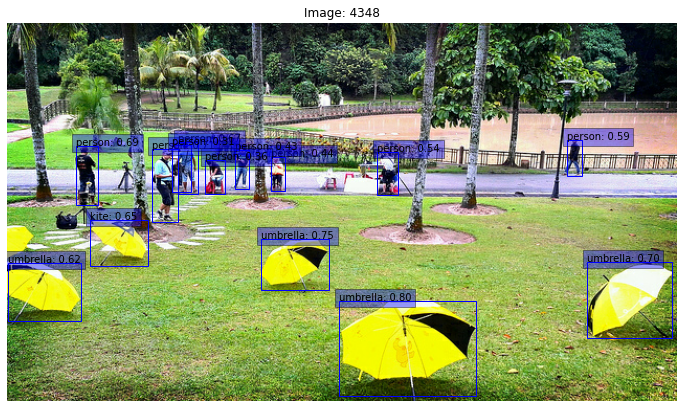

In [27]:
idx = 4348
image = read_image(image_paths[idx])
serving_input = prepare_image_fn(image=image,
                                 image_id=tf.constant([idx], dtype=tf.int32))
tik = time()
detections = serving_fn(**serving_input)
toc = time()

valid_detections = detections['valid_detections'][0].numpy()
boxes = detections['boxes'][0][:valid_detections].numpy()
classes = [
    label_map[str(idx)]
    for idx in detections['classes'][0][:valid_detections].numpy()
]
scores = detections['scores'][0][:valid_detections].numpy()

#  Visualize detections
visualize_detections(image,
                     boxes,
                     classes,
                     scores,
                     title='Image: {}'.format(idx),
                     score_threshold=0.30,
                     save=False,
                     filename='image_{}.png'.format(idx))

print('Inference time: {:.2f} ms'.format((toc - tik) * 1000))

### Inference on a folder of  images

In [ ]:
fps = 1.0
num_samples = len(image_paths)

for idx, image_path in enumerate(image_paths):
    t1 = time()
    image = read_image(image_path)
    t2 = time()
    serving_input = prepare_image_fn(
        image=image,
        image_id=tf.constant(idx, dtype=tf.int32))
    
    t3 = time()
    detections = serving_fn(**serving_input)
    t4 = time()
    
    fps = 0.95 * fps + 0.05 * (1 / (t4 - t3))
    eta = (num_samples - (idx + 1)) / fps

    print(
        '\rProcessed {}/{} images | ETA: {:.2f} secs | FPS(detection): {:.1f}/sec | forward_pass_with_nms: {:.3f} ms | image_reading: {:.3f} ms | image_preprocessing: {:.3f} ms'
        .format(idx + 1, len(image_paths), eta, fps, t4 - t3,
                t2 - t1, t3 - t2),
        end='')

Processed 3581/5000 images | ETA: 137.7 secs | FPS(detection): 10.3/sec | forward_pass_with_nms: 0.097 ms | image_reading: 0.003 ms | image_preprocessing: 0.002 mss